<a href="https://colab.research.google.com/github/ahmed123234/zoomcamp-ML/blob/main/model_evaluation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [119]:
import pandas as pd

!wget -O course_lead_scoring.csv https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv

--2025-10-20 11:46:36--  https://raw.githubusercontent.com/alexeygrigorev/datasets/master/course_lead_scoring.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 80876 (79K) [text/plain]
Saving to: ‘course_lead_scoring.csv’

course_lead_scoring 100%[===================>]  78.98K  --.-KB/s    in 0.002s  

2025-10-20 11:46:36 (45.1 MB/s) - ‘course_lead_scoring.csv’ saved [80876/80876]



In [120]:
# --- Data Loading and Preparation ---
# Load the dataset
df = pd.read_csv('course_lead_scoring.csv')

# Convert all column names to lowercase and replace spaces with underscores
df.columns = df.columns.str.lower().str.replace(' ', '_')

# Separate categorical and numerical features
categorical_cols = list(df.dtypes[df.dtypes == 'object'].index)
numerical_cols = list(df.dtypes[df.dtypes != 'object'].index)

# Handle missing values
for col in categorical_cols:
    df[col] = df[col].fillna('NA')

for col in numerical_cols:
    df[col] = df[col].fillna(0.0)

# Target variable is 'converted'
target = 'converted'
numerical_cols.remove(target) # Remove target from numerical features list

print("Data preparation complete. ✓\n")

Data preparation complete. ✓



In [121]:
from sklearn.model_selection import train_test_split
# --- Data Splitting ---
df_full_train, df_test = train_test_split(df, test_size=0.2, random_state=1)
df_train, df_val = train_test_split(df_full_train, test_size=0.25, random_state=1) # 0.25 * 0.8 = 0.2

# Get target variables
y_train = df_train[target].values
y_val = df_val[target].values
y_test = df_test[target].values

# Remove target variable from dataframes
del df_train[target]
del df_val[target]
del df_test[target]

print(f"Data split into: Train ({len(df_train)}), Validation ({len(df_val)}), Test ({len(df_test)}) ✓\n")

Data split into: Train (876), Validation (293), Test (293) ✓



In [122]:
from sklearn.metrics import roc_auc_score

print("## Question 1: ROC AUC feature importance")
# Method 1:Univariate ROC AUC (Feature Selection)

numerical_features = ['lead_score', 'number_of_courses_viewed', 'interaction_count', 'annual_income']
auc_scores = {}

for col in numerical_features:
    auc = roc_auc_score(y_train, df_train[col])
    if auc < 0.5:
        auc = roc_auc_score(y_train, -df_train[col])
    auc_scores[col] = auc

print("ROC AUC scores for numerical features:")
for col, score in auc_scores.items():
    print(f"'{col}': {score:.4f}")

best_auc_feature = max(auc_scores, key=auc_scores.get)
print(f"\nThe numerical variable with the highest AUC is: '{best_auc_feature}'")

## Question 1: ROC AUC feature importance
ROC AUC scores for numerical features:
'lead_score': 0.6145
'number_of_courses_viewed': 0.7636
'interaction_count': 0.7383
'annual_income': 0.5520

The numerical variable with the highest AUC is: 'number_of_courses_viewed'


In [123]:
import numpy as np
from sklearn.feature_extraction import DictVectorizer
from sklearn.linear_model import LogisticRegression

# define the train function
def train(df_train, y_train, C=1.0):
   # One-Hot Encoding using DictVectorizer
  train_dicts = df_train.to_dict(orient='records')
  val_dicts = df_val.to_dict(orient='records')

  dv = DictVectorizer(sparse=False)
  X_train = dv.fit_transform(train_dicts)
  X_val = dv.transform(val_dicts)


  model = LogisticRegression(solver='liblinear', C=C, max_iter=1000)
  # Fit the model with the transformed data
  model.fit(X_train, y_train)
  return dv, model, X_val

# define predict function
def predict (df, dv, model):
  dicts = df[categorical_cols + numerical_cols].to_dict(orient='records')

  X = dv.transform(dicts)
  y_pred = model.predict_proba(X)[:, 1]

  return y_pred

In [124]:
from sklearn.metrics import roc_auc_score
from sklearn.metrics import accuracy_score
import numpy as np # Import numpy for thresholding

print("## Question 2: Training the model")

# Train the model
dv, model, X_val = train(df_train, y_train)

# Make predictions and calculate AUC
y_pred_proba = predict(df_val, dv, model) # Get probability of the positive class

# calculate the accuracy by thresholding the probabilities
y_pred_binary = (y_pred_proba >= 0.5).astype(int) # Convert probabilities to binary predictions
accuracy = accuracy_score(y_val, y_pred_binary) # Use binary predictions for accuracy

auc_score = roc_auc_score(y_val, y_pred_proba)

# print the accuracy
print(f"The accuracy is: {accuracy:.3f}")

print(f"The AUC of the logistic regression model on the validation dataset is: {auc_score:.3f}")

## Question 2: Training the model
The accuracy is: 0.700
The AUC of the logistic regression model on the validation dataset is: 0.817


## Question 1: ROC AUC Feature Importance (Permutation)
Baseline Model ROC AUC: 0.8171

--- ROC AUC Feature Importance (Permutation) ---
number_of_courses_viewed        0.1968
interaction_count               0.1535
employment_status=unemployed    0.0058
lead_source=paid_ads            0.0049
lead_source=referral            0.0041
lead_score                      0.0017
industry=education              0.0011
employment_status=employed      0.0008
industry=technology             0.0004
location=north_america          0.0004
dtype: float64


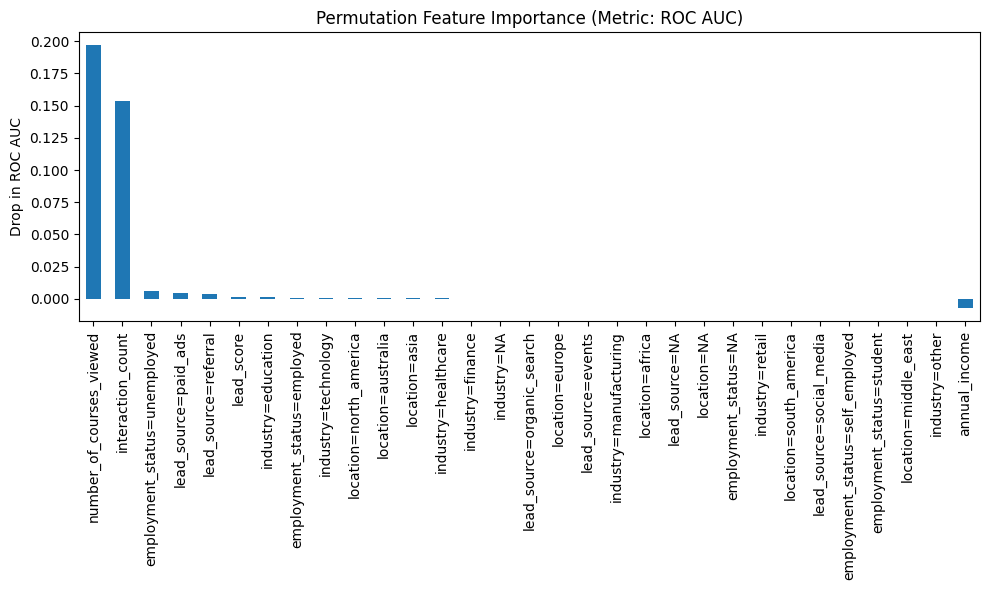

In [125]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt
# Method 2:  ROC AUC Feature Importance (Permutation)
print("## Question 1: ROC AUC Feature Importance (Permutation)")

# 1. Calculate Baseline ROC AUC Score
# We use predict_proba to get the probability of the positive class (class 1)
y_pred_proba = model.predict_proba(X_val)[:, 1]
baseline_auc = roc_auc_score(y_val, y_pred_proba)

print(f"Baseline Model ROC AUC: {baseline_auc:.4f}\n")

# 2. Calculate Permutation Feature Importance (using ROC AUC)

# The 'scoring' parameter specifies the metric to measure performance drop.
# 'roc_auc' is the key we need.
result = permutation_importance(
    estimator=model,
    X=X_val,
    y=y_val,  # Use y_val for evaluation
    scoring='roc_auc',  # Use ROC AUC as the performance metric
    n_repeats=10,       # Number of times to shuffle/repeat for stability
    random_state=42,
    n_jobs=-1           # Use all CPU cores for faster computation
)

# 3. Process and Display Results

# Create a Series of features and their mean importance
feature_importances = pd.Series(
    result.importances_mean,
    index=dv.get_feature_names_out() # Use dv to get feature names for encoded data
)

# Sort features by importance (largest drop first)
sorted_importances = feature_importances.sort_values(ascending=False)

print("--- ROC AUC Feature Importance (Permutation) ---")
print(sorted_importances.head(10).round(4))

# Optional: Plot the results
fig, ax = plt.subplots(figsize=(10, 6))
sorted_importances.plot.bar(ax=ax)
ax.set_title("Permutation Feature Importance (Metric: ROC AUC)")
ax.set_ylabel("Drop in ROC AUC")
fig.tight_layout()
plt.show()

In [126]:
def evaluate_precision_recall(threshold):
  # confusion matrix
  actual_positves = y_val == 1
  actual_negatives = y_val == 0
  y_pred = y_pred_proba
  predicted_positives = (y_pred >= threshold)
  predicted_negatives = (y_pred < threshold)

  # find the true positive
  true_positives = sum(actual_positves & predicted_positives)

  # find the false positive
  false_positives = sum(actual_negatives & predicted_positives)

  # find the true negatives
  true_negatives = sum(actual_negatives & predicted_negatives)

  # find the false negatives
  false_negatives = sum(actual_positves & predicted_negatives)


  precision = true_positives / (true_positives + false_positives)

  recall = true_positives / (true_positives + false_negatives)
  return precision, recall



Threshold: 0.00, Precision: 0.5836, Recall: 1.0000
Threshold: 0.01, Precision: 0.5836, Recall: 1.0000
Threshold: 0.02, Precision: 0.5836, Recall: 1.0000
Threshold: 0.03, Precision: 0.5836, Recall: 1.0000
Threshold: 0.04, Precision: 0.5836, Recall: 1.0000
Threshold: 0.05, Precision: 0.5836, Recall: 1.0000
Threshold: 0.06, Precision: 0.5836, Recall: 1.0000
Threshold: 0.07, Precision: 0.5836, Recall: 1.0000
Threshold: 0.08, Precision: 0.5836, Recall: 1.0000
Threshold: 0.09, Precision: 0.5836, Recall: 1.0000
Threshold: 0.10, Precision: 0.5836, Recall: 1.0000
Threshold: 0.11, Precision: 0.5836, Recall: 1.0000
Threshold: 0.12, Precision: 0.5836, Recall: 1.0000
Threshold: 0.13, Precision: 0.5836, Recall: 1.0000
Threshold: 0.14, Precision: 0.5836, Recall: 1.0000
Threshold: 0.15, Precision: 0.5836, Recall: 1.0000
Threshold: 0.16, Precision: 0.5836, Recall: 1.0000
Threshold: 0.17, Precision: 0.5836, Recall: 1.0000
Threshold: 0.18, Precision: 0.5836, Recall: 1.0000
Threshold: 0.19, Precision: 0.5

/tmp/ipython-input-365212580.py:22: RuntimeWarning: invalid value encountered in scalar divide
  precision = true_positives / (true_positives + false_positives)


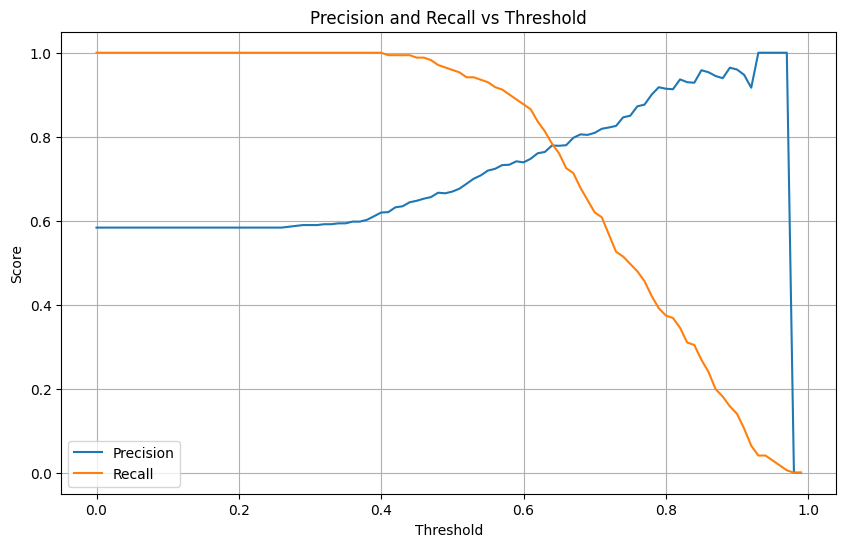


Approximate intersection threshold where precision and recall curves intersect: 0.98


In [127]:
thresholds = np.arange(0.0, 1.0, 0.01)

precision_scores = []
recall_scores = []

for threshold in thresholds:
    precision, recall = evaluate_precision_recall(threshold)

    if np.isnan(precision):
        precision = 0
    if np.isnan(recall):
        recall = 0
    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
# We can find the intersection by looking for where precision is approximately equal to recall
intersection_threshold = None
min_diff = float('inf')

for i in range(len(thresholds)):
    diff = abs(precision_scores[i] - recall_scores[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresholds[i]

print(f"\nApproximate intersection threshold where precision and recall curves intersect: {intersection_threshold:.2f}")

## Question 3: Precision and Recall
Threshold: 0.00, Precision: 0.5836, Recall: 1.0000
Threshold: 0.01, Precision: 0.5836, Recall: 1.0000
Threshold: 0.02, Precision: 0.5836, Recall: 1.0000
Threshold: 0.03, Precision: 0.5836, Recall: 1.0000
Threshold: 0.04, Precision: 0.5836, Recall: 1.0000
Threshold: 0.05, Precision: 0.5836, Recall: 1.0000
Threshold: 0.06, Precision: 0.5836, Recall: 1.0000
Threshold: 0.07, Precision: 0.5836, Recall: 1.0000
Threshold: 0.08, Precision: 0.5836, Recall: 1.0000
Threshold: 0.09, Precision: 0.5836, Recall: 1.0000
Threshold: 0.10, Precision: 0.5836, Recall: 1.0000
Threshold: 0.11, Precision: 0.5836, Recall: 1.0000
Threshold: 0.12, Precision: 0.5836, Recall: 1.0000
Threshold: 0.13, Precision: 0.5836, Recall: 1.0000
Threshold: 0.14, Precision: 0.5836, Recall: 1.0000
Threshold: 0.15, Precision: 0.5836, Recall: 1.0000
Threshold: 0.16, Precision: 0.5836, Recall: 1.0000
Threshold: 0.17, Precision: 0.5836, Recall: 1.0000
Threshold: 0.18, Precision: 0.5836, Recall: 1.

/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


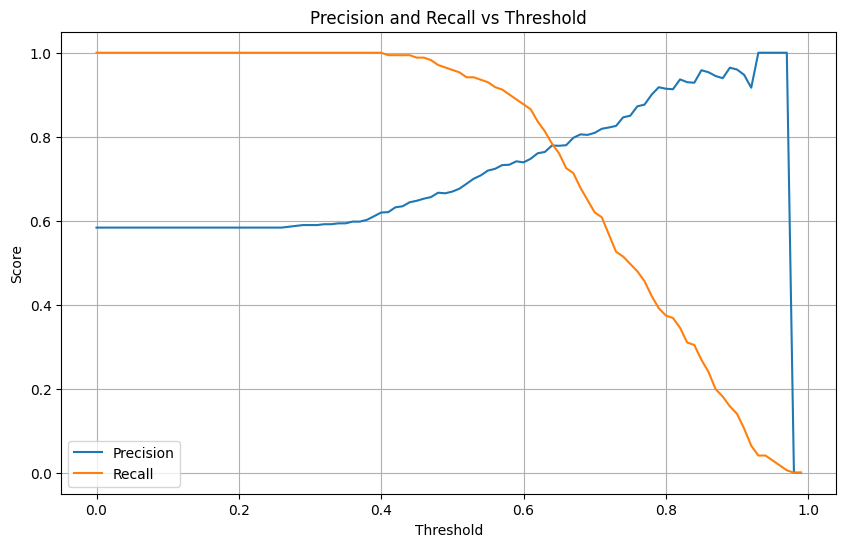


Approximate intersection threshold where precision and recall curves intersect: 0.98


In [128]:
import matplotlib.pyplot as plt
from sklearn.metrics import precision_score, recall_score

print("## Question 3: Precision and Recall")

thresholds = np.arange(0.0, 1.0, 0.01)
# print(thresholds)
precision_scores = []
recall_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    precision = precision_score(y_val, y_pred_threshold)
    recall = recall_score(y_val, y_pred_threshold)

    precision_scores.append(precision)
    recall_scores.append(recall)

    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}")

# Plotting the curves
plt.figure(figsize=(10, 6))
plt.plot(thresholds, precision_scores, label='Precision')
plt.plot(thresholds, recall_scores, label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.title('Precision and Recall vs Threshold')
plt.legend()
plt.grid(True)
plt.show()

# Find the intersection point
# We can find the intersection by looking for where precision is approximately equal to recall
intersection_threshold = None
min_diff = float('inf')

for i in range(len(thresholds)):
    diff = abs(precision_scores[i] - recall_scores[i])
    if diff < min_diff:
        min_diff = diff
        intersection_threshold = thresholds[i]

print(f"\nApproximate intersection threshold where precision and recall curves intersect: {intersection_threshold:.2f}")

In [129]:
def evaluate_f1_score(precision, recall):
  if precision + recall == 0:
    return 0
  return 2 * (precision * recall) / (precision + recall)


In [130]:
# find f1_score for each threshold
f1_scores = []
for i in range(len(precision_scores)):
  f1 = evaluate_f1_score(precision_scores[i], recall_scores[i])
  f1_scores.append(f1)
  print(f"Threshold: {thresholds[i]:.2f}, F1 Score: {f1:.4f}")

# find the best score and the best threshold
max_f1 = max(f1_scores)
best_threshold_f1 = thresholds[f1_scores.index(max_f1)]

print(f"The maximal F1 score is: {max_f1:.4f}")
print(f"The threshold at which the F1 score is maximal is: {best_threshold_f1:.2f}")


Threshold: 0.00, F1 Score: 0.7371
Threshold: 0.01, F1 Score: 0.7371
Threshold: 0.02, F1 Score: 0.7371
Threshold: 0.03, F1 Score: 0.7371
Threshold: 0.04, F1 Score: 0.7371
Threshold: 0.05, F1 Score: 0.7371
Threshold: 0.06, F1 Score: 0.7371
Threshold: 0.07, F1 Score: 0.7371
Threshold: 0.08, F1 Score: 0.7371
Threshold: 0.09, F1 Score: 0.7371
Threshold: 0.10, F1 Score: 0.7371
Threshold: 0.11, F1 Score: 0.7371
Threshold: 0.12, F1 Score: 0.7371
Threshold: 0.13, F1 Score: 0.7371
Threshold: 0.14, F1 Score: 0.7371
Threshold: 0.15, F1 Score: 0.7371
Threshold: 0.16, F1 Score: 0.7371
Threshold: 0.17, F1 Score: 0.7371
Threshold: 0.18, F1 Score: 0.7371
Threshold: 0.19, F1 Score: 0.7371
Threshold: 0.20, F1 Score: 0.7371
Threshold: 0.21, F1 Score: 0.7371
Threshold: 0.22, F1 Score: 0.7371
Threshold: 0.23, F1 Score: 0.7371
Threshold: 0.24, F1 Score: 0.7371
Threshold: 0.25, F1 Score: 0.7371
Threshold: 0.26, F1 Score: 0.7371
Threshold: 0.27, F1 Score: 0.7387
Threshold: 0.28, F1 Score: 0.7403
Threshold: 0.2

In [131]:
from sklearn.metrics import f1_score

print("## Question 4: F1 score")

thresholds = np.arange(0.0, 1.01, 0.01)
f1_scores = []

for threshold in thresholds:
    y_pred_threshold = (y_pred_proba >= threshold).astype(int)
    f1 = f1_score(y_val, y_pred_threshold)
    f1_scores.append(f1)

# print the scores for each threshold
for i in range(len(thresholds)):
    print(f"Threshold: {thresholds[i]:.2f}, F1 Score: {f1_scores[i]:.4f}")

# Find the threshold with the maximal F1 score
max_f1 = max(f1_scores)
best_threshold_f1 = thresholds[f1_scores.index(max_f1)]

print(f"The maximal F1 score is: {max_f1:.4f}")
print(f"The threshold at which the F1 score is maximal is: {best_threshold_f1:.2f}")

## Question 4: F1 score
Threshold: 0.00, F1 Score: 0.7371
Threshold: 0.01, F1 Score: 0.7371
Threshold: 0.02, F1 Score: 0.7371
Threshold: 0.03, F1 Score: 0.7371
Threshold: 0.04, F1 Score: 0.7371
Threshold: 0.05, F1 Score: 0.7371
Threshold: 0.06, F1 Score: 0.7371
Threshold: 0.07, F1 Score: 0.7371
Threshold: 0.08, F1 Score: 0.7371
Threshold: 0.09, F1 Score: 0.7371
Threshold: 0.10, F1 Score: 0.7371
Threshold: 0.11, F1 Score: 0.7371
Threshold: 0.12, F1 Score: 0.7371
Threshold: 0.13, F1 Score: 0.7371
Threshold: 0.14, F1 Score: 0.7371
Threshold: 0.15, F1 Score: 0.7371
Threshold: 0.16, F1 Score: 0.7371
Threshold: 0.17, F1 Score: 0.7371
Threshold: 0.18, F1 Score: 0.7371
Threshold: 0.19, F1 Score: 0.7371
Threshold: 0.20, F1 Score: 0.7371
Threshold: 0.21, F1 Score: 0.7371
Threshold: 0.22, F1 Score: 0.7371
Threshold: 0.23, F1 Score: 0.7371
Threshold: 0.24, F1 Score: 0.7371
Threshold: 0.25, F1 Score: 0.7371
Threshold: 0.26, F1 Score: 0.7371
Threshold: 0.27, F1 Score: 0.7387
Threshold: 0.28, F1 Scor

In [132]:
from sklearn.model_selection import KFold

def cross_validation(df_full_train, n_splits=5, C=1.0):
  scores = []
  df_full_train = df_full_train.reset_index(drop=True)

  kfold = KFold(n_splits=n_splits, shuffle=True, random_state=1)

  for train_idx, val_idx in kfold.split(df_full_train):
    df_train = df_full_train.iloc[train_idx]
    df_val = df_full_train.iloc[val_idx]

    y_train = df_train.converted.values
    y_val = df_val.converted.values

    del df_train[target]
    del df_val[target]


    dv, model, X_val = train(df_train, y_train, C)
    y_pred = predict(df_val, dv, model)
    auc = roc_auc_score(y_val, y_pred)
    scores.append(auc)

    return np.mean(scores), np.std(scores)

In [133]:
# print auc for each fold and mean and sd
mean_auc, std_auc = cross_validation(df_full_train, n_splits=5)
print('%.3f +- %.3f' % (mean_auc, std_auc))

0.806 +- 0.000


In [134]:
from sklearn.model_selection import KFold

print("## Question 5: 5-Fold CV")

# Use df_full_train for cross-validation
df_full_train = df_full_train.reset_index(drop=True)

# Initialize KFold
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

auc_scores_cv = []

# Iterate over folds
for train_idx, val_idx in kfold.split(df_full_train):
    df_train_fold = df_full_train.iloc[train_idx]
    df_val_fold = df_full_train.iloc[val_idx]

    y_train_fold = df_train_fold[target].values
    y_val_fold = df_val_fold[target].values

    del df_train_fold[target]
    del df_val_fold[target]

    # One-Hot Encoding using DictVectorizer
    train_dicts_fold = df_train_fold.to_dict(orient='records')
    val_dicts_fold = df_val_fold.to_dict(orient='records')

    dv_fold = DictVectorizer(sparse=False)
    X_train_fold = dv_fold.fit_transform(train_dicts_fold)
    X_val_fold = dv_fold.transform(val_dicts_fold)

    # Train the model
    model_fold = LogisticRegression(solver='liblinear', C=1.0, max_iter=1000)
    model_fold.fit(X_train_fold, y_train_fold)

    # Make predictions and calculate AUC
    y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
    auc_score_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
    auc_scores_cv.append(auc_score_fold)

# Calculate mean and standard deviation of AUC scores
mean_auc = np.mean(auc_scores_cv)
std_auc = np.std(auc_scores_cv)

print(f"AUC scores for each fold: {auc_scores_cv}")
print(f"Mean AUC across folds: {mean_auc:.4f}")
print(f"Standard deviation of AUC across folds: {std_auc:.4f}")

## Question 5: 5-Fold CV
AUC scores for each fold: [np.float64(0.8060745924216483), np.float64(0.8713738368910783), np.float64(0.7754320118852139), np.float64(0.8018368617683685), np.float64(0.8558272713202291)]
Mean AUC across folds: 0.8221
Standard deviation of AUC across folds: 0.0358


In [135]:
print("## Question 6: Hyperparameter Tuning")

c_values = [0.000001, 0.001, 1]
kfold = KFold(n_splits=5, shuffle=True, random_state=1)

results = []

for C in c_values:
    auc_scores_cv = []
    for train_idx, val_idx in kfold.split(df_full_train):
        df_train_fold = df_full_train.iloc[train_idx]
        df_val_fold = df_full_train.iloc[val_idx]

        y_train_fold = df_train_fold[target].values
        y_val_fold = df_val_fold[target].values

        del df_train_fold[target]
        del df_val_fold[target]

        train_dicts_fold = df_train_fold.to_dict(orient='records')
        val_dicts_fold = df_val_fold.to_dict(orient='records')

        dv_fold = DictVectorizer(sparse=False)
        X_train_fold = dv_fold.fit_transform(train_dicts_fold)
        X_val_fold = dv_fold.transform(val_dicts_fold)

        model_fold = LogisticRegression(solver='liblinear', C=C, max_iter=1000, random_state=42)
        model_fold.fit(X_train_fold, y_train_fold)

        y_pred_proba_fold = model_fold.predict_proba(X_val_fold)[:, 1]
        auc_score_fold = roc_auc_score(y_val_fold, y_pred_proba_fold)
        auc_scores_cv.append(auc_score_fold)

    mean_auc = np.mean(auc_scores_cv)
    std_auc = np.std(auc_scores_cv)
    results.append({'C': C, 'mean_auc': mean_auc, 'std_auc': std_auc})

print("Results for different C values:")
for result in results:
    print(f"C={result['C']}: Mean AUC={result['mean_auc']:.3f}, Std AUC={result['std_auc']:.3f}")

# Find the best C
best_result = None
for result in results:
    if best_result is None or result['mean_auc'] > best_result['mean_auc']:
        best_result = result
    elif result['mean_auc'] == best_result['mean_auc']:
        if result['std_auc'] < best_result['std_auc']:
            best_result = result
        elif result['std_auc'] == best_result['std_auc']:
            if result['C'] < best_result['C']:
                best_result = result

print(f"\nBest C value: {best_result['C']}")
print(f"Best Mean AUC: {best_result['mean_auc']:.3f}")
print(f"Best Std AUC: {best_result['std_auc']:.3f}")

## Question 6: Hyperparameter Tuning
Results for different C values:
C=1e-06: Mean AUC=0.560, Std AUC=0.024
C=0.001: Mean AUC=0.867, Std AUC=0.029
C=1: Mean AUC=0.822, Std AUC=0.036

Best C value: 0.001
Best Mean AUC: 0.867
Best Std AUC: 0.029
